# This is for plotting velocity variance under neutral condition #
Note: 1. data with diag_csat_ins >= 65 are discarded in advance.\
2. B1 (the 4th level) uses different CSAT model

2022-6-15

In [2]:
# This jupyter notebook command inserts matplotlib graphics in 
# to the workbook
%matplotlib inline

# import packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
import pickle
import time
from matplotlib.pyplot import figure
import scipy.io as sio
from datetime import date, timedelta
from math import *
from scipy.stats import gmean
from scipy import ndimage
from scipy import stats
# directories
IN_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/basic_processed_data/"
IN_DIRECTORY2 = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/processed_data/"
msk_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/mask_data/"
OUT_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/neutral_data_20200925_20210423/"
PLOT_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/fig_neutral/"
ins_var=['u_ins'] # 36000 instantaneous variables per hour 
tur_var=['u_tur','v_tur','w_tur'] # 36000 instantaneous variables per hour 
avg_var=['u_avg','u_star','L_H2','v_avg','u_std','v_std','w_std','T_avg','rot_ang_v'] # 1 averaged variable per hour
flg_var=['diag_csat_ins','sig_irga_ins']
msk = ['mask_INL_all_1d']
neutral_var = ['neutral_case','u_star_mean','temp_stability','kappa_m2',
             'kappa_m2_stability_corrected','u_star_dev','u_star_m1_sel_dev',
             'u_star_m1_dev','u_star_m1_sel','u_star_m1','u_star_fit','u_star_m2',
             'zo_m1','zo_m1_sel','u_avg_neutral','v_avg_neutral','w_avg_neutral',
             'u_star_m1_dev_abs_mean','u_star_m1_sel_dev_abs_mean','u_star_m2_dev_abs_mean',
             'u_std_neutral','v_std_neutral','w_std_neutral',
             'ist_before','r2_m1','r2_m1_sel','r2_m2',
             'u_star_m2_dif']
out_var=['delta0','z_delta0','A1_fit','r2']

## define constants and labels ##

In [3]:
sonum    =12                       # number of sonic
z        = np.array([1.2,2,3.5,6,8.2,12.8,
                     15.8,23,30.3,40.2,50.6,60.5])  # height of sonic above ground, m
frequency=10                   # sampling frequency, Hz
time_avg =3600                  # average time, s
rpat = time_avg*frequency           # number of lines for a loop

# physical constants (or values that are assumed constant)
Rw  = 461.5     # ideal gas constant for water vapor, J/kg*K
Rd  = 287.05    # ideal gas constant for dry air, J/kg*K
Lv  = 1000*2257 # latent heat of vaporization (water), J/kg
Cp  = 1005      # approximate constant pressure specific heat of air, J/kg*K
kappa   = 0.4       # Von Karman constant
g   = 9.81      # acceleration of gravity, m/s^2
list_col = ['C1','C2','C3','C4','B1','B2','B3','B4','A1','A2','A3','A4']

A1 = 1 # constants in Townsend's formulations for the normalized standard deviation of horizontal velocity
B1 = 2.5

# selected levels
# list_sel = range(5,11) # from level 6 to level 11
list_sel_m1 = np.array([5,6,7,8,9,10]) # from level 6 to level 11
list_sel_m2 = np.array([5,6,7,8,9,10])
list_sel_delta = np.array([7,8,9,10]) # from level 8 to level 11
# list_all = np.array([0,1,2,3,6,7,8,9,10,11])
xtick_labels = ["1.2","2","3.5","6","8.2","12.8","15.8","23","30.3","40.2","50.6","60.5"]

load_tur = False

## define functions ##

In [4]:
def date_list(sdate,edate):
    """method used for creating date list"""
    delta = edate - sdate       # as timedelta
    day = [sdate+timedelta(days=x) for x in range(delta.days+1)]
    return day

def Gauss(N, sigma):
    x = np.linspace(1,N,N)- N/2
    Gaussian_filtered = np.exp(-(x**2)/(2*sigma**2))/(sigma*sqrt(2*pi))
    Gaussian_filtered = Gaussian_filtered/np.nansum(Gaussian_filtered) # normalize
    return Gaussian_filtered
    
def BOX(N, size):
    x = np.linspace(1,N,N).T- N/2
    BOX_filtered = np.zeros([N,1])
    msk = abs(x)<(size/2)
    BOX_filtered[msk] = 1
    # for i in range(N):
    #     if (x[i]>size/2) or (x[i]<-size/2):
    #         BOX_filtered[i] = 0
    #     else:
    #         BOX_filtered[i] = 1
    BOX_filtered = BOX_filtered/np.nansum(BOX_filtered)  # normalize
    return BOX_filtered

def conv_circ( signal, ker ):
    '''
        signal: real 1D array
        ker: real 1D array
        signal and ker must have same shape
    '''
    return np.real(np.fft.ifft( np.fft.fft(signal)*np.fft.fft(ker) ))

def filter_fixed_delta(u_tur,v_tur,w_tur,u_avg,frequency,select_for_fit_variance,
                       init_delta_value,do_plot):
    u_tur_save = u_tur
    x_temp = np.nanmean(u_tur[:,select_for_fit_variance], axis=1)
    y_temp = np.nanmean(v_tur[:,select_for_fit_variance], axis=1)
    z_temp = np.nanmean(w_tur[:,select_for_fit_variance], axis=1)
    filter_frequency = init_delta_value 
    filter_size = np.round(filter_frequency/frequency) # the number of points to be averaged
    gaussFilter = Gauss(len(x_temp),(1/12*filter_size**2)**0.5)
    # print(filter_size)
    #! filter_size is the number of points to be averaged in order to go from 'frequency' to 'filter_frequency'
    #! the reason 'sigma^2 = 1/12 filter_size^2' is used is given in
    #! Pope's book
    # boxFilter = BOX(len(x_temp),filter_size)
    # print(len(boxFilter))
    #! filter_size is the number of points to be averaged in order to go from 'frequency' to 'filter_frequency'
    xfilt = conv_circ(x_temp,gaussFilter)
    yfilt = conv_circ(y_temp,gaussFilter)
    zfilt = conv_circ(z_temp,gaussFilter)
    # xfilt = conv_circ(x_temp,boxFilter)
    # yfilt = conv_circ(y_temp,boxFilter)
    # zfilt = conv_circ(z_temp,boxFilter)
    # print(boxFilter[0:100])
    # print(x_temp[0:100])
    # print(xfilt[0:100])
    nan_msk=np.isnan(xfilt)
    if all(nan_msk):
        print('nan value for xfilt')
        return (None,None,None,None,None,None,None)  

    #! for i in range(sonum):
    u_tur=u_tur-xfilt[:,np.newaxis]
    v_tur=v_tur-yfilt[:,np.newaxis]
    w_tur=w_tur-zfilt[:,np.newaxis]
        
    uw=np.nanmean(u_tur*w_tur,axis=0)
    u_std=np.nanstd(u_tur,axis=0)
    v_std=np.nanstd(v_tur,axis=0)
    w_std=np.nanstd(w_tur,axis=0) 
    # print('done!')
    
    return (u_tur,v_tur,w_tur,u_std,v_std,w_std,uw)

# Load neutral data #

In [9]:
for var in neutral_var:
    a_file = open(OUT_DIRECTORY + var +'.pkl', "rb")
    globals()[var] = pickle.load(a_file)
    a_file.close()

## Load instantaneous data and process data ##

In [10]:
nn = len(neutral_case)
A1_fit = np.zeros(nn) * np.nan
r2 = np.zeros(nn) * np.nan
delta0 = np.zeros(nn) * np.nan
z_delta0 = np.zeros((nn,sonum)) * np.nan
for i in range(nn):
    strday = str(neutral_case[i][0].strftime("%Y%m%d"))
    print('start processing:'+ strday+'_'+str(neutral_case[i][1]))
    if load_tur:
        # load tur variables
        for var in tur_var:
            a_file = open(OUT_DIRECTORY + var +'_' + strday +'_'+str(neutral_case[i][1]) +'.pkl', "rb")
            globals()[var] = pickle.load(a_file)    
            a_file.close()
    # 1.find delta
    x_vector = np.log(z[list_sel_delta])
    y_vector = u_std_neutral[i,list_sel_delta]**2/(u_star_fit[i]**2)
    # compute delta by least square fit from multiple levels
    b = np.linalg.lstsq(np.ones([len(x_vector),1]),(y_vector + A1*x_vector)[:])
    delta0[i] = exp((b[0][0]-B1)/A1)
    z_delta0[i,:] = z/delta0[i]
    
    # 2.compute A1, B1 by linear regression
    res = stats.linregress(-np.log(z[list_sel_delta]), y_vector)
    A1_fit[i] = res.slope
    r2[i] = res.rvalue**2

start processing:20200925_16
start processing:20200925_17
start processing:20200925_19
start processing:20201010_16
start processing:20201010_21
start processing:20201012_17
start processing:20201012_18
start processing:20201013_14
start processing:20201013_16
start processing:20201013_18
start processing:20201013_19
start processing:20201016_17
start processing:20201017_17
start processing:20201018_16
start processing:20201019_9
start processing:20201019_17
start processing:20201021_9
start processing:20201021_15
start processing:20201021_16
start processing:20201021_18
start processing:20201022_4
start processing:20201030_16
start processing:20201030_17
start processing:20201115_11
start processing:20201119_11
start processing:20201119_12
start processing:20201119_13
start processing:20201119_14
start processing:20201119_15
start processing:20201119_16
start processing:20201119_17
start processing:20210103_16
start processing:20210123_11
start processing:20210124_5
start processing:2

## Save var data ##

In [12]:
for var in out_var:
    a_file = open(OUT_DIRECTORY + var + '.pkl', "wb")
    pickle.dump(eval(var), a_file)
    a_file.close()

# Load var data #

In [13]:
for var in out_var:
    a_file = open(OUT_DIRECTORY + var +'.pkl', "rb")
    globals()[var] = pickle.load(a_file)
    a_file.close()

In [31]:
# %%time
# set up time period and initialize variables
Sdate = date(2020,9,25)
# Sdate = date(2021,2,26)
# Edate = date(2020,9,26)
Edate = date(2021,4,23)
ds = date_list(Sdate,Edate)
# u_star_mean, u_star_fit = [],[]
# slope_m1, slope_m1_sel, slope_m2 = [],[],[]
# intecept_m1, intecept_m1_sel, intecept_m2 = [],[],[]
# zo_m1, zo_m1_sel, zo_m2 = [],[],[]
# u_star_m1, u_star_m1_sel,u_star_m2 = [],[],[]
# u_star_dev = [] # 2d: #cases*12levels
# u_star_m1_dev,u_star_m1_sel_dev,u_star_m2_dev = [],[],[] # 2d
# u_star_m1_dev_mean,u_star_m1_sel_dev_mean,u_star_m2_dev_mean = [],[],[]
# u_star_m2_dev_max = []
# kappa_m2 = [] # 1d
# neutral_case = [] # list
# u_avg_neutral,v_avg_neutral, rot_ang_v_neutral, T_avg_neutral = [],[],[],[] # 2d
# temp_stability = [] # 1d
# kappa_m2_stability_corrected = [] # 1d
# zo_m2_stability_corrected = [] # 1d
# delta,delta2 = [],[] # boundary layer height
# A1_fit,A1_fit2 = [],[]
ist_before0,ist_after0 = np.ones([1,sonum]),np.ones([1,sonum])
ist_before,ist_after = [],[]
u_std_neutral,v_std_neutral,w_std_neutral = [],[],[]
u_std_neutral_filt,v_std_neutral_filt,w_std_neutral_filt = [],[],[]
u_std_plus2,v_std_plus2,w_std_plus2,uw_plus2 = [],[],[],[]
z_delta0,z_delta2 = [],[]
# print('!')
for day in ds:
    strday = str(day.strftime("%Y%m%d"))
    fp_stats = IN_DIRECTORY + 'u_ins_' + strday +'.pkl'
    if (not os.path.isfile(fp_stats)):
        print(day.strftime("%Y%m%d")+' do not exist')
        continue
    # print('start loading:'+ strday)
    
    # load neutral mask
    b_file = open(msk_DIR + 'mask_neutral_' + strday +'.pkl', "rb")
    mask_neutral = pickle.load(b_file)    
    b_file.close()
    if not any(mask_neutral):
        continue
    # load masks
    for var in msk:
        a_file = open(msk_DIR + var +'_' + strday +'.pkl', "rb")
        globals()[var] = pickle.load(a_file)    
        a_file.close()
    nan_msk=np.isnan(mask_INL_all_1d)
    if all(nan_msk):
        continue        
    # load avg variables
    for var in avg_var: 
        a_file = open(IN_DIRECTORY + var +'_' + strday +'.pkl', "rb")
        globals()[var] = pickle.load(a_file)    
        a_file.close() 
    # load tur variables
    for var in tur_var: 
        a_file = open(IN_DIRECTORY + var +'_' + strday +'.pkl', "rb")
        globals()[var] = pickle.load(a_file)    
        a_file.close()
    # ---------------- compute log wind profile
    if do_processing:
        print('start processing:'+ strday)       
        for i in range(24): # loop of hour
            if mask_neutral[i] and (~nan_msk[i]):
                print('neutral case - Hour ' + str(i+1))
            
#                 # compute variations of u_star{ec} across vertical levels, 
#                 # the mean value is calculated by selected levels
#                 u_star_mean0 = np.nanmean(u_star[i,list_sel_m1])
#                 u_star_mean = np.append(u_star_mean, u_star_mean0) # mean of the selected level
#                 u_star_dev = np.append(u_star_dev, (u_star[i,:]-u_star_mean0)/u_star_mean0, axis=0)
                
#                 # -----compute u_star by method 1, fit with kappa = 0.4 and using all level data
#                 mask1 = ~np.isnan(z)
#                 mask2 = ~np.isnan(u_avg[i,:])
#                 mask = mask1 & mask2 # mask out nan values
#                 p1,p2 = np.polyfit(np.log(z[mask]), u_avg[i,mask], deg = 1)
#                 slope_m1 = np.append(slope_m1, p1)
#                 intecept_m1 = np.append(intecept_m1,p2)
#                 zo_m1 = np.append(zo_m1,exp(-p2/p1)) # momentum roughness length
                
#                 u_star_m1_0 = kappa*p1
#                 u_star_m1 = np.append(u_star_m1,u_star_m1_0)
                
#                 # compute variations of u_star across all levels, 
#                 # the mean value is calculated by method 1 using all level
#                 u_star_m1_dev0 = (u_star[i,:]-u_star_m1_0)/u_star_m1_0
#                 u_star_m1_dev = np.append(u_star_m1_dev, u_star_m1_dev0, axis=0)  
#                 # mean absolute error of u_star_m1_dev0 
#                 u_star_m1_dev_mean = np.append(u_star_m1_dev_mean, 
#                                                    np.nanmean(abs(u_star_m1_dev0[:])))
#                 print('finish:ec')
                
#                 # -----compute u_star by method 1, fit with kappa = 0.4 and using selected level data
#                 p3,p4 = np.polyfit(np.log(z[list_sel_m1]), u_avg[i,list_sel_m1], deg = 1)
#                 slope_m1_sel = np.append(slope_m1_sel, p3)
#                 intecept_m1_sel = np.append(intecept_m1_sel,p4)
#                 zo_m1_sel = np.append(zo_m1_sel,exp(-p4/p3)) # momentum roughness length
                
#                 u_star_m1_sel0 = kappa*p3
#                 u_star_m1_sel = np.append(u_star_m1_sel,u_star_m1_sel0)
                
#                 # compute variations of u_star across all levels
#                 # the mean value is calculated by method 1 using selected level
#                 u_star_m1_sel_dev0 = (u_star[i,:]-u_star_m1_sel0)/u_star_m1_sel0
#                 u_star_m1_sel_dev = np.append(u_star_m1_sel_dev, u_star_m1_sel_dev0, axis=0) 
                
#                 u_star_m1_sel_dev_mean = np.append(u_star_m1_sel_dev_mean, 
#                                                    np.nanmean(abs(u_star_m1_sel_dev0[list_sel_m1])))
                
#                 # ----- method2, fit with ec measured ustar and using selected data
#                 # This method will give nearly the same zo as method 1 if using
#                 # the same selected data, the only difference is the kappa value and the u_star
#                 # 1. u_star is calculated by interpolate to the ground level
#                 p_u_1,p_u_2 = np.polyfit(z[list_sel_m2], u_star[i,list_sel_m2], deg = 1)
#                 u_star_fit = np.append(u_star_fit, p_u_2)
                
#                 # 2. fit the log wind profile
#                 p5,p6 = np.polyfit(np.log(z[list_sel_m2]), u_avg[i,list_sel_m2], deg = 1)
#                 slope_m2 = np.append(slope_m2, p5)
#                 intecept_m2_sel = np.append(intecept_m2,p6)
#                 zo_m2 = np.append(zo_m2,exp(-p6/p5)) # momentum roughness length
                
#                 u_star_m2_0 = np.nanmean(u_star[i,list_sel_m2])
#                 u_star_m2 = np.append(u_star_m2,u_star_m2_0)
#                 kappa_m2_0 = p_u_2/p5 # using the interpolated u_star
#                 kappa_m2 = np.append(kappa_m2, kappa_m2_0)  
                
#                 temp_stability0 = gmean(z[list_sel_m2])/ndimage.median(L_H2[i,list_sel_m2])
#                 temp_stability = np.append(temp_stability,temp_stability0)
#                 if temp_stability0 >0: # stable condition
#                     k_cor = kappa_m2_0*(1+5*temp_stability0)
#                     kappa_m2_stability_corrected = np.append(kappa_m2_stability_corrected,k_cor)
#                 else: # unstable condition
#                     k_cor = kappa_m2_0*(1-16*temp_stability0)**(-1/4)
#                     kappa_m2_stability_corrected = np.append(kappa_m2_stability_corrected,k_cor)
                
#                 # stability corrected roughness length
#                 zo_cor = exp(-p6/(p_u_2/k_cor)) # this needs to be revisited
#                 zo_m2_stability_corrected = np.append(zo_m2_stability_corrected, zo_cor)
                
#                 u_star_m2_dev0 = (u_star[i,:]-p_u_2)/p_u_2
#                 u_star_m2_dev = np.append(u_star_m2_dev, u_star_m2_dev0, axis=0)                
#                 u_star_m2_dev_mean = np.append(u_star_m2_dev_mean, 
#                                                    np.nanmean(abs(u_star_m2_dev0[:])))
#                 u_star_m2_dev_max = np.append(u_star_m2_dev_max, 
#                                                    np.nanmax(abs(u_star_m2_dev0[:])))
#                 # find delta
#                 x_vector = np.log(z[list_sel_delta])
#                 y_vector = u_std[i,list_sel_delta]**2/(p_u_2**2)
                
#                 # compute delta by least square fit
#                 b = np.linalg.lstsq(np.ones([len(x_vector),1]),(y_vector + A1*x_vector)[:])
#                 delta0 = exp((b[0][0]-B1)/A1)
#                 delta = np.append(delta, delta0)
#                 z_delta0 = np.append(z_delta0,z/delta0)
#                 print('finish:m2')
                
#                 # compute A1, B1 by log fit
#                 p7,p8 = np.polyfit(-np.log(z[list_sel_delta]), y_vector, deg = 1)
#                 A1_fit = np.append(A1_fit, p7)
#                 # B1_fit = append(B1_fit, p8)
                
#                 # derived variables
#                 u_avg_neutral = np.append(u_avg_neutral, u_avg[i,:])
#                 v_avg_neutral = np.append(v_avg_neutral, v_avg[i,:])
#                 rot_ang_v_neutral = np.append(rot_ang_v_neutral, rot_ang_v[i,:])
#                 T_avg_neutral = np.append(T_avg_neutral, T_avg[i,:])
                
#                 u_std_neutral = np.append(u_std_neutral, u_std[i,:])
#                 v_std_neutral = np.append(v_std_neutral, v_std[i,:])
#                 w_std_neutral = np.append(w_std_neutral, w_std[i,:])
                
#                 for j in range(sonum):
#                     u_tur_temp = u_tur3d[i,:,j].reshape([-1,12]) # split each hour into 12 chunks
#                     cvm = np.nanmean(np.nanvar(u_tur_temp,axis=0))
#                     ist_before0[0,j] = abs(cvm-np.nanvar(u_tur3d[i,:,j]))/np.nanvar(u_tur3d[i,:,j])
#                     ist_before = np.append(ist_before, ist_before0)
                print('start:filter')
                if do_filtering:
                    do_plot = 0
                    (u_tur,v_tur,w_tur,u_std_neutral2,v_std_neutral2,
                      w_std_neutral2,uw_neutral2)=filter_fixed_delta(u_tur3d[i,:,:],
                                                                    v_tur3d[i,:,:],w_tur3d[i,:,:],u_avg[i,:],
                                                                   frequency,list_sel_m1,250,do_plot)
                    print('!')
                    if np.all(u_tur == None):
                        continue
                    u_std_neutral_filt = np.append(u_std_neutral_filt,u_std_neutral2)
                    
                    for j in range(sonum):
                        u_tur_temp = u_tur[:,j].reshape([-1,12]) # split each hour into 12 chunks
                        cvm = np.nanmean(np.nanvar(u_tur_temp,axis=0))
                        ist_after0[0,j] = abs(cvm-np.nanvar(u_tur[:,j]))/np.nanvar(u_tur[:,j])
                        ist_after = np.append(ist_after, ist_after0)
                        
                    x_vector = np.log(z[list_sel_delta])
                    y_vector = u_std_neutral2[list_sel_delta]**2/(p_u_2**2)
                    print('finish:filter')

                    # compute delta by least square fit
                    b = np.linalg.lstsq(np.ones([len(x_vector),1]),(y_vector + A1*x_vector)[:])
                    delta00 = exp((b[0][0]-B1)/A1)
                    delta2 = np.append(delta2, delta00)
                    # print('!!')
    
                    # compute A1, B1 by log fit
                    p9,p10 = np.polyfit(-np.log(z[list_sel_delta]), y_vector, deg = 1)
                    A1_fit2 = np.append(A1_fit2, p9)
                    # B1_fit2 = np.append(B1_fit2, p10)
                    
                    z_delta2 = np.append(z_delta2,z/delta00)
                    u_std_plus2 = np.append(u_std_plus2,u_std_neutral2**2/(p_u_2**2))
                    v_std_plus2 = np.append(v_std_plus2,v_std_neutral2**2/(p_u_2**2))
                    w_std_plus2 = np.append(w_std_plus2,w_std_neutral2**2/(p_u_2**2))
                    uw_plus2 = np.append(uw_plus2,-uw_neutral2/(p_u_2**2))
                    neutral_case.append([day,i+1]) # time index of neutral cases


    print('finish processing:'+ strday)
    print('------------------------')
# u_star_m2 = u_star_mean
u_star_dev = np.reshape(u_star_dev,(-1,12))
u_star_m1_dev = np.reshape(u_star_m1_dev,(-1,12))
u_star_m1_sel_dev = np.reshape(u_star_m1_sel_dev,(-1,12))
u_star_m2_dev = np.reshape(u_star_m2_dev,(-1,12))
u_avg_neutral = np.reshape(u_avg_neutral,(-1,12))
v_avg_neutral = np.reshape(v_avg_neutral,(-1,12))
u_std_plus2 = np.reshape(u_std_plus2,(-1,12))

start processing:20200925
neutral case - Hour 16
finish:ec
finish:m2
start:filter
!
finish:filter
neutral case - Hour 17
finish:ec
finish:m2
start:filter
!
finish:filter
neutral case - Hour 19
finish:ec
finish:m2
start:filter
!
finish:filter
finish processing:20200925
------------------------
start processing:20201008
finish processing:20201008
------------------------
start processing:20201010
neutral case - Hour 16
finish:ec
finish:m2
start:filter
!
finish:filter
neutral case - Hour 21
finish:ec
finish:m2
start:filter
!
finish:filter
finish processing:20201010
------------------------
start processing:20201011
finish processing:20201011
------------------------
start processing:20201012
neutral case - Hour 17
finish:ec
finish:m2
start:filter
!
finish:filter
neutral case - Hour 18
finish:ec
finish:m2
start:filter
!
finish:filter
finish processing:20201012
------------------------
start processing:20201013
neutral case - Hour 14
finish:ec
finish:m2
start:filter
!
finish:filter
neutral 

In [14]:
%whos ndarray list 

Variable                       Type       Data/Info
---------------------------------------------------
A1_fit                         ndarray    71: 71 elems, type `float64`, 568 bytes
avg_var                        list       n=9
delta0                         ndarray    71: 71 elems, type `float64`, 568 bytes
flg_var                        list       n=2
ins_var                        list       n=1
ist_before                     ndarray    71x12: 852 elems, type `float64`, 6816 bytes
kappa_m2                       ndarray    71: 71 elems, type `float64`, 568 bytes
kappa_m2_stability_corrected   ndarray    71: 71 elems, type `float64`, 568 bytes
list_col                       list       n=12
list_sel_delta                 ndarray    4: 4 elems, type `int64`, 32 bytes
list_sel_m1                    ndarray    6: 6 elems, type `int64`, 48 bytes
list_sel_m2                    ndarray    6: 6 elems, type `int64`, 48 bytes
msk                            list       n=1
neutral_case       

# Let's start plotting #

In [15]:
## PLOTTING STUFF
## define useful fonts
plt.rc('text', usetex=True)
# plt.rc('font', family='sans-serif')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
font_size = 14
do_plot = True

## A1 vs stability, IST, R2, u*_dev ##

In [28]:
y_temp = abs(A1_fit-1.3)/1.3
y_msk = y_temp<3
y_plus = y_temp[y_msk]
y_mean = np.nanmean(y_plus)
y_sigma = np.nanstd(y_plus)

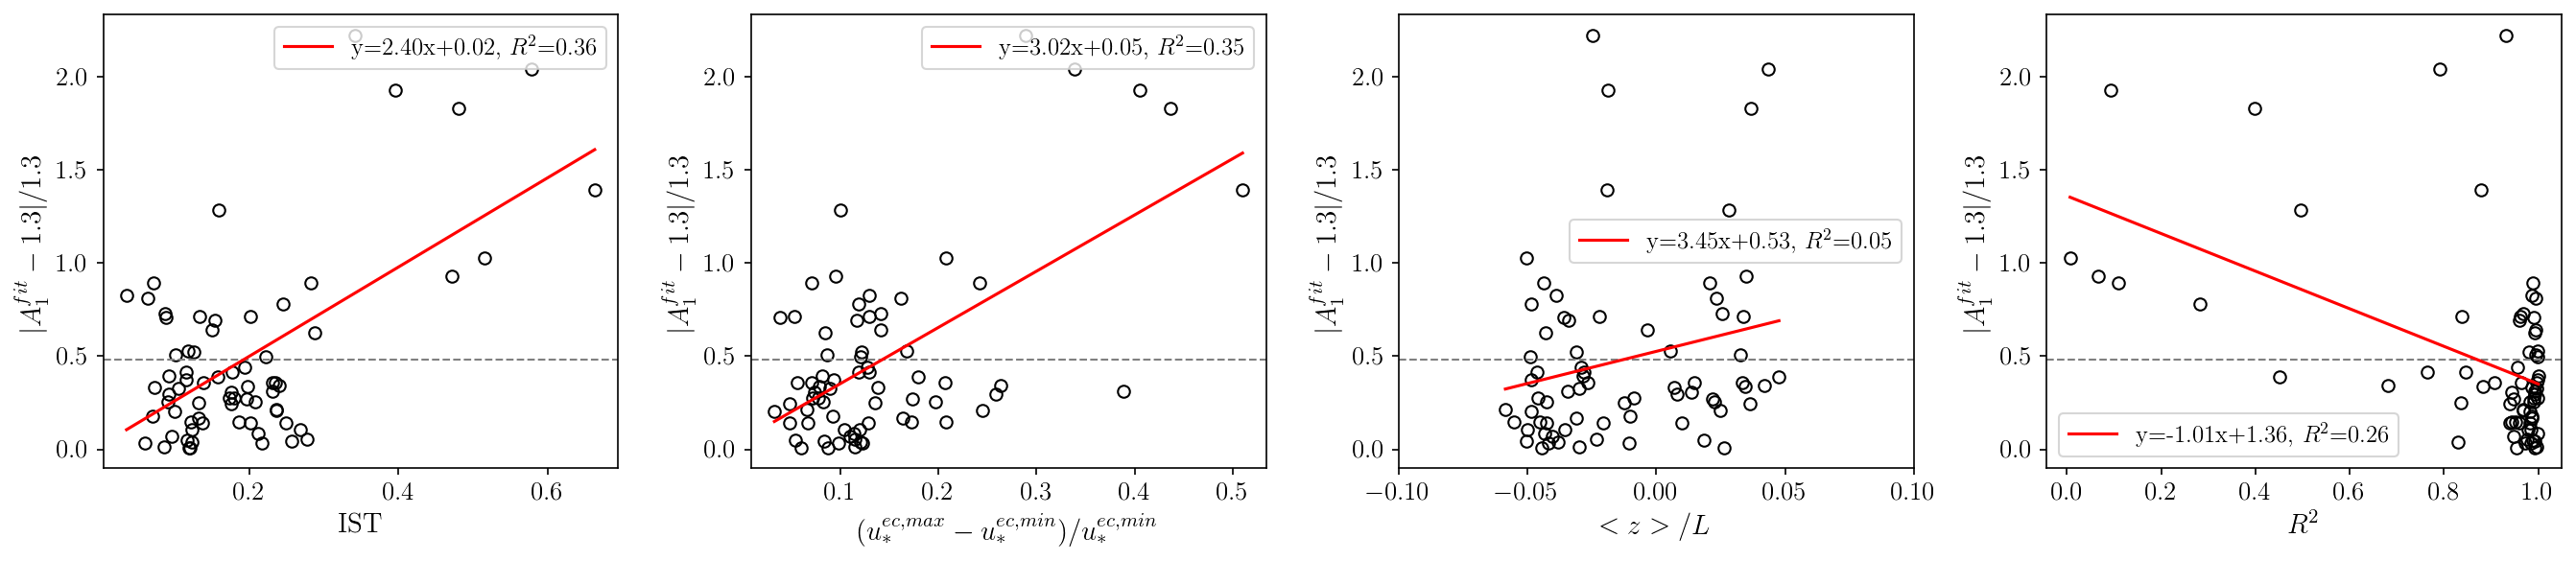

In [31]:
# A_msk = A1_fit>0
# A1_fit = abs(A_fit-1.3)/1.3
# A_msk = ~np.isnan(A1_fit)
# A_mean = np.nanmean(A1_fit[A_msk])
fig = plt.figure(figsize=(18,4), dpi=150,tight_layout=True)

ax1 = fig.add_subplot(141) 
ist = np.nanmean(ist_before, axis=1)
plt.plot(ist[y_msk],y_plus,'o',color = 'k',markerfacecolor='none')
plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'IST', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(ist[y_msk], y_plus)
x = np.sort(ist[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
# plt.plot(ist[A1_fit<=0],A1_fit[A1_fit<=0],'o',color = 'blue',markerfacecolor='none')

ax2 = fig.add_subplot(142) 
plt.plot(u_star_m2_dif[y_msk],y_plus,'o',color = 'k',markerfacecolor='none')
plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'$(u_*^{ec,max}-u_*^{ec,min})/u_*^{ec,min}$', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(u_star_m2_dif[y_msk], y_plus)
x = np.sort(u_star_m2_dif[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

ax3 = fig.add_subplot(143) 
plt.plot(temp_stability[y_msk],y_plus,'o',color = 'k',markerfacecolor='none')
plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'\rm $<z>/L$', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
plt.xlim(-0.1,0.1)
# linear regression
slope, intercept,r,_,_ = stats.linregress(temp_stability[y_msk], y_plus)
x = np.sort(temp_stability[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

ax4 = fig.add_subplot(144) 
plt.plot(r2[y_msk],y_plus,'o',color = 'k',markerfacecolor='none')
plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'$R^2$', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(r2[y_msk], y_plus)
x = np.sort(r2[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
# plt.plot(r2[A1_fit<=0],A1_fit[A1_fit<=0],'o',color = 'blue',markerfacecolor='none')

# plt.plot(temp_stability[A1_fit<=0],A1_fit[A1_fit<=0],'o',color = 'blue',markerfacecolor='none')
# plt.plot(u_star_m1_dev_abs_mean[A1_fit<=0],A1_fit[A1_fit<=0],'o',color = 'blue',markerfacecolor='none')
# if do_plot:
#     plt.savefig(PLOT_DIRECTORY + 'A1_pos_zol_ist_r2_error.jpg', dpi=200)

### R2>0.9 ###

In [12]:
A_msk = np.logical_and(r2>=0.9,A1_fit>0)
# calculate percentiles of A1_fit
index = [5, 50, 95]
perc_numpy = [np.percentile(A1_fit[A_msk], i, interpolation='nearest') for i in index]
# calculate sigma
A_mean = np.nanmean(A1_fit[A_msk])
A_sigma = np.nanstd(A1_fit[A_msk])

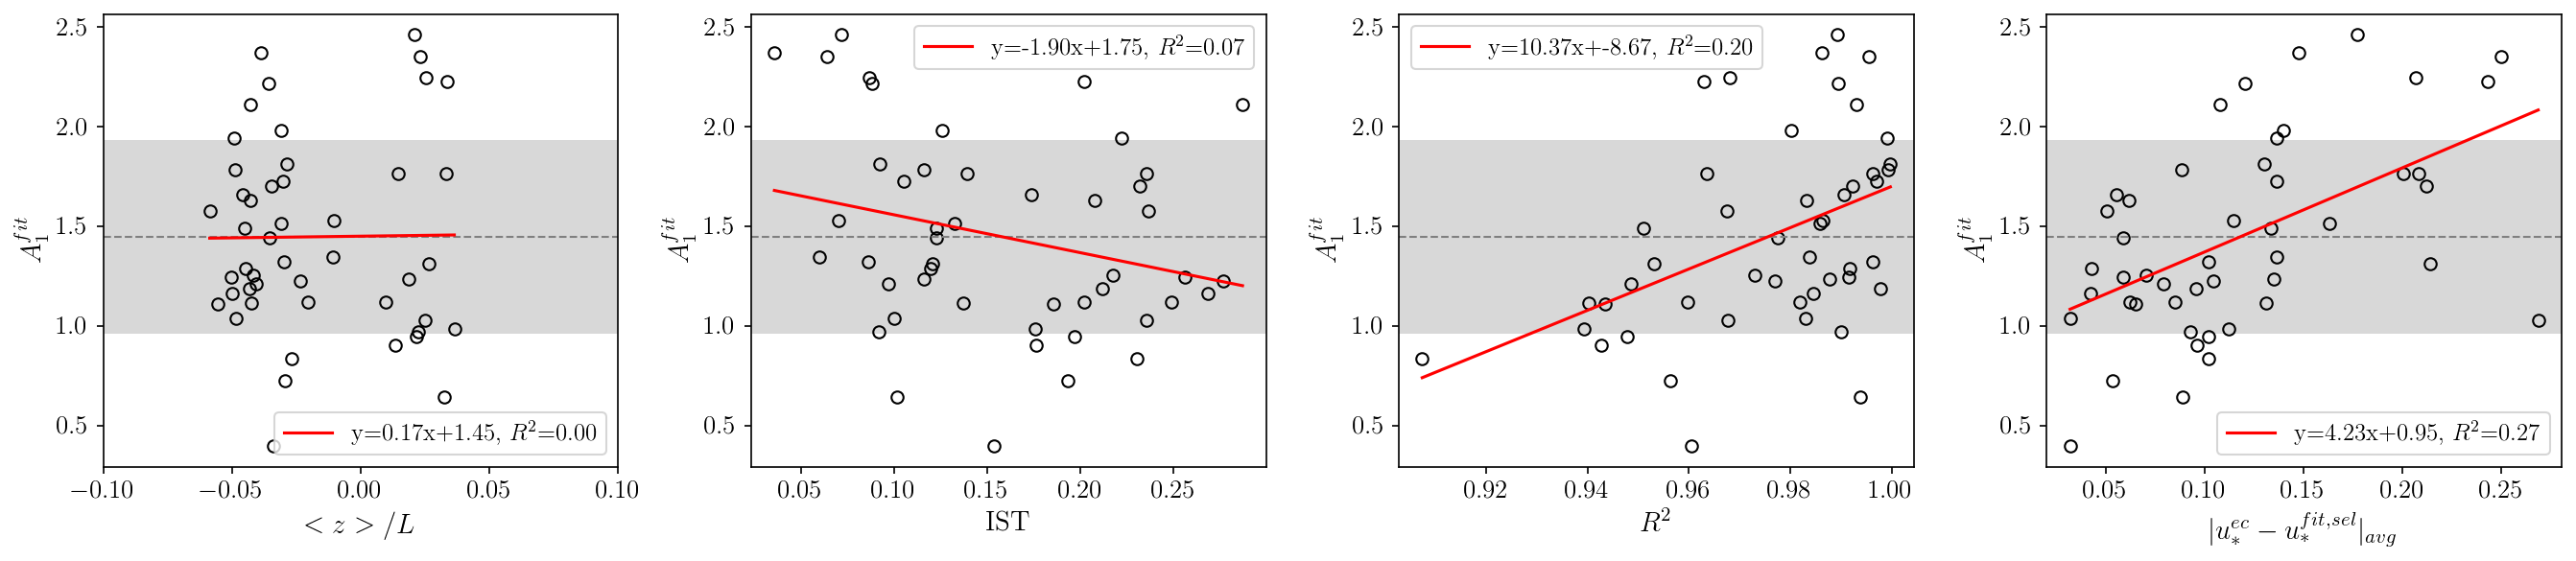

In [14]:
fig = plt.figure(figsize=(18,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(141) 
plt.plot(temp_stability[A_msk],A1_fit[A_msk],'o',color = 'k',markerfacecolor='none')
plt.axhline(y=A_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'\rm $<z>/L$', fontsize=font_size)
plt.ylabel(r'$A_1^{fit}$', fontsize=font_size)
plt.xlim(-0.1,0.1)
# linear regression
slope, intercept,r,_,_ = stats.linregress(temp_stability[A_msk], A1_fit[A_msk])
x = np.sort(temp_stability[A_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax1.legend(fontsize=12)
plt.axhspan(A_mean-A_sigma, A_mean+A_sigma, facecolor='0.5', alpha=0.3)

ax2 = fig.add_subplot(142) 
ist = np.nanmean(ist_before, axis=1)
plt.plot(ist[A_msk],A1_fit[A_msk],'o',color = 'k',markerfacecolor='none')
plt.axhline(y=A_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'IST', fontsize=font_size)
plt.ylabel(r'$A_1^{fit}$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(ist[A_msk], A1_fit[A_msk])
x = np.sort(ist[A_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.axhspan(A_mean-A_sigma, A_mean+A_sigma, facecolor='0.5', alpha=0.3)

ax3 = fig.add_subplot(143) 
plt.plot(r2[A_msk],A1_fit[A_msk],'o',color = 'k',markerfacecolor='none')
plt.axhline(y=A_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'$R^2$', fontsize=font_size)
plt.ylabel(r'$A_1^{fit}$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(r2[A_msk], A1_fit[A_msk])
x = np.sort(r2[A_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.axhspan(A_mean-A_sigma, A_mean+A_sigma, facecolor='0.5', alpha=0.3)

ax4 = fig.add_subplot(144) 
plt.plot(u_star_m1_dev_abs_mean[A_msk],A1_fit[A_msk],'o',color = 'k',markerfacecolor='none')
plt.axhline(y=A_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'$|u_*^{ec}-u_*^{fit,sel}|_{avg}$', fontsize=font_size)
plt.ylabel(r'$A_1^{fit}$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(u_star_m1_dev_abs_mean[A_msk], A1_fit[A_msk])
x = np.sort(u_star_m1_dev_abs_mean[A_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.axhspan(A_mean-A_sigma, A_mean+A_sigma, facecolor='0.5', alpha=0.3)
if do_plot:
    plt.savefig(PLOT_DIRECTORY + 'A1_r209_zol_ist_r2_error.jpg', dpi=200)

## A1 vs stability ##

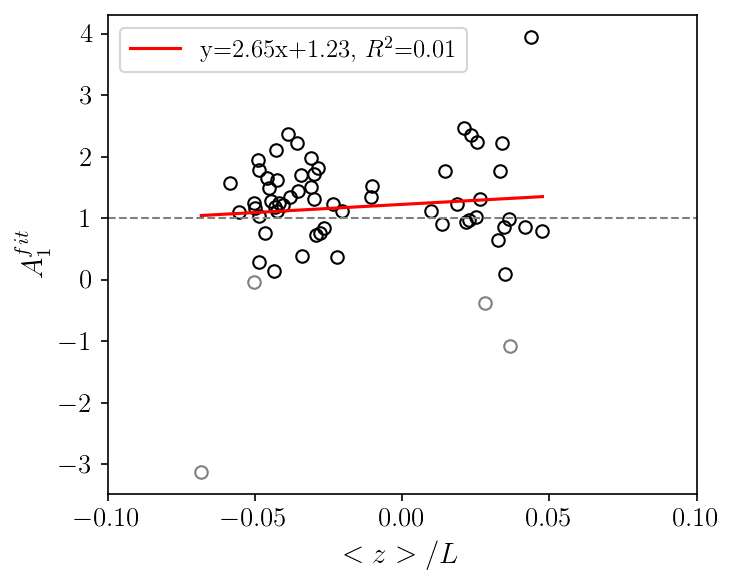

In [17]:
fig = plt.figure(figsize=(5,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(111) 
plt.plot(temp_stability[A_msk],A1_fit[A_msk],'o',color = 'k',markerfacecolor='none')
plt.axhline(y=1, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'\rm $<z>/L$', fontsize=font_size)
plt.ylabel(r'$A_1^{fit}$', fontsize=font_size)
plt.xlim(-0.1,0.1)
# linear regression
slope, intercept,r,_,_ = stats.linregress(temp_stability, A1_fit)
x = np.sort(temp_stability)
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax1.legend(fontsize=12)
plt.plot(temp_stability[A1_fit<=0],A1_fit[A1_fit<=0],'o',color = 'grey',markerfacecolor='none')

## neutral case variance ##

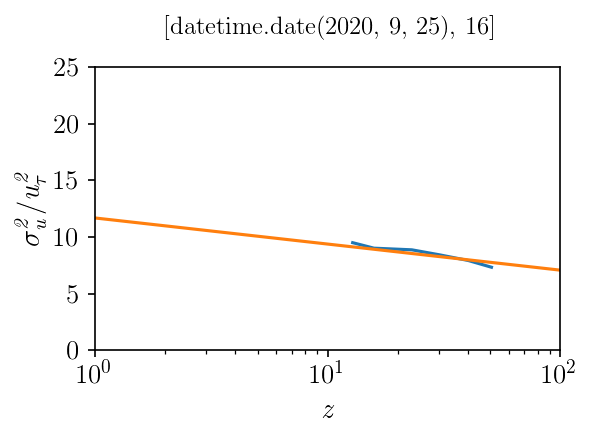

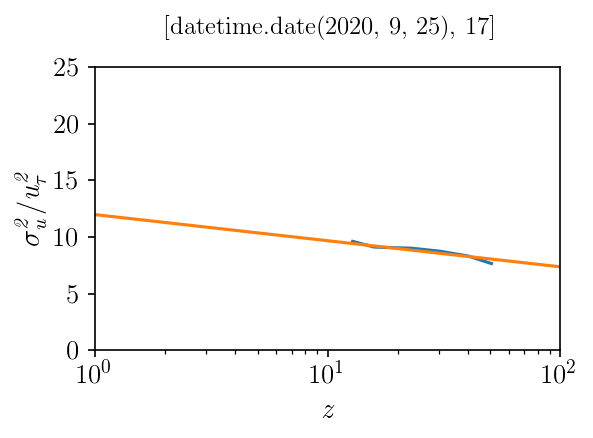

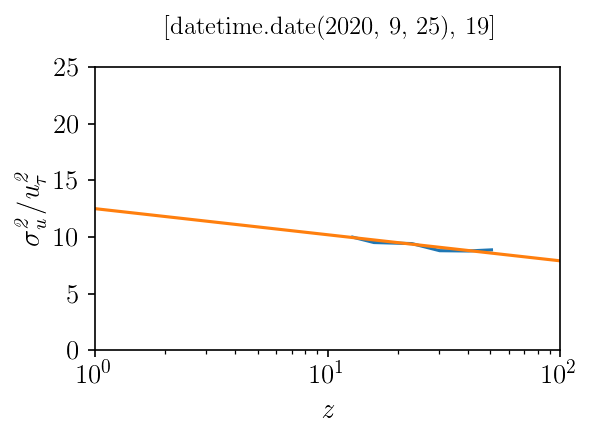

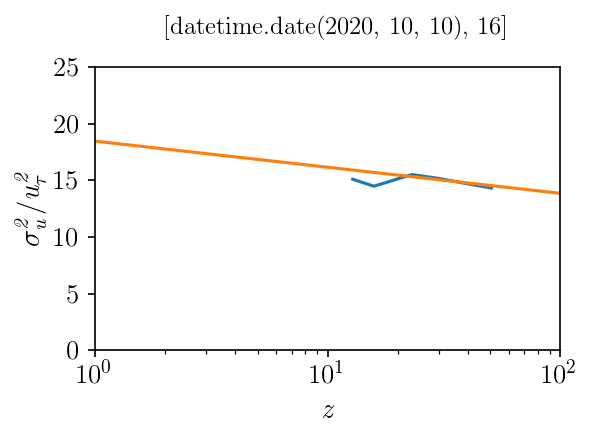

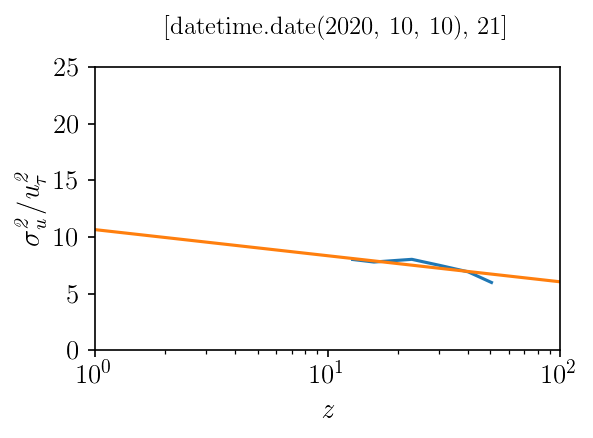

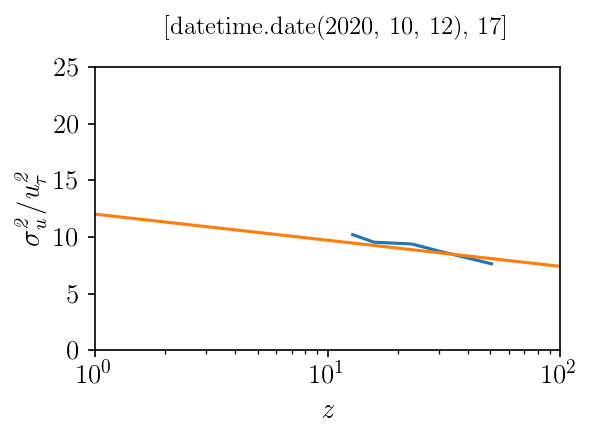

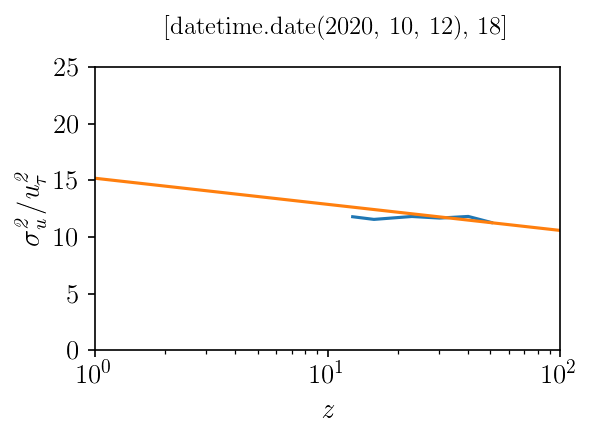

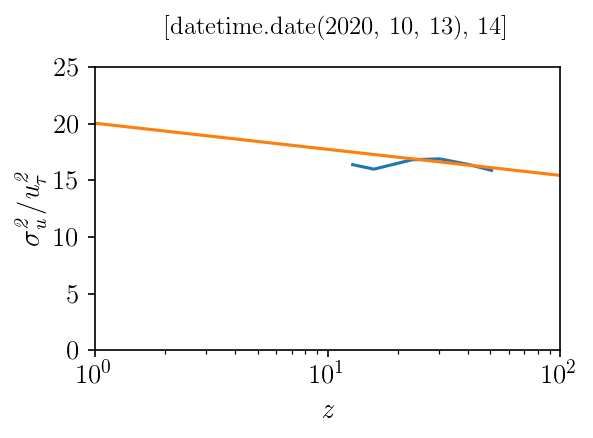

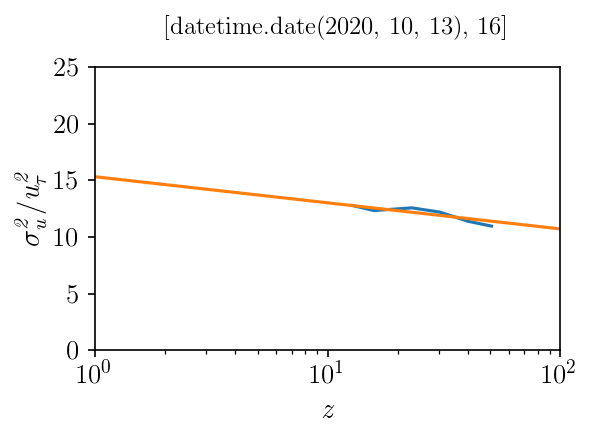

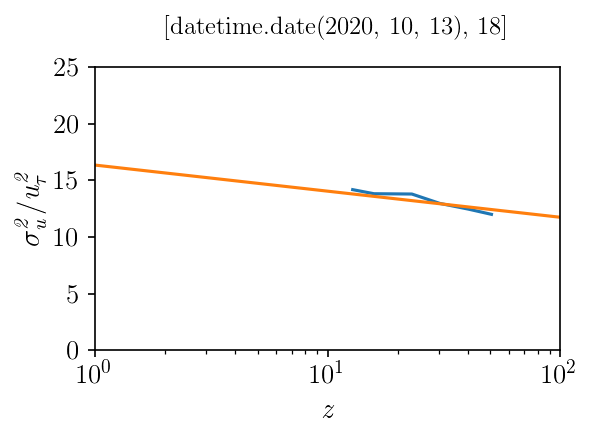

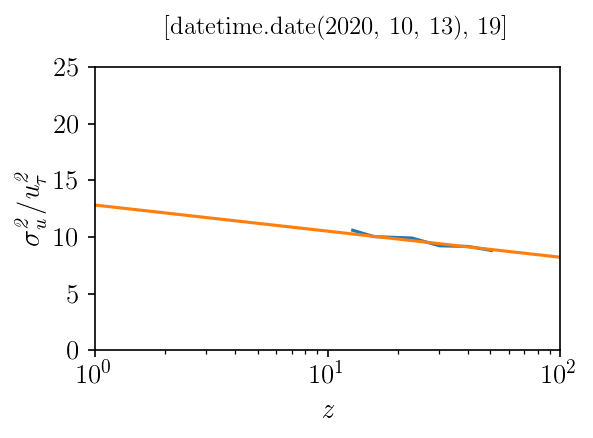

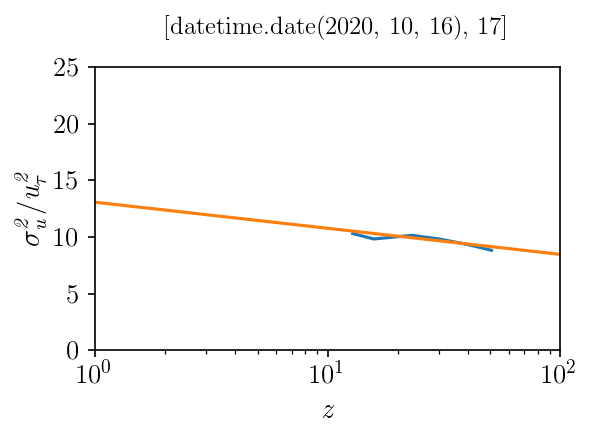

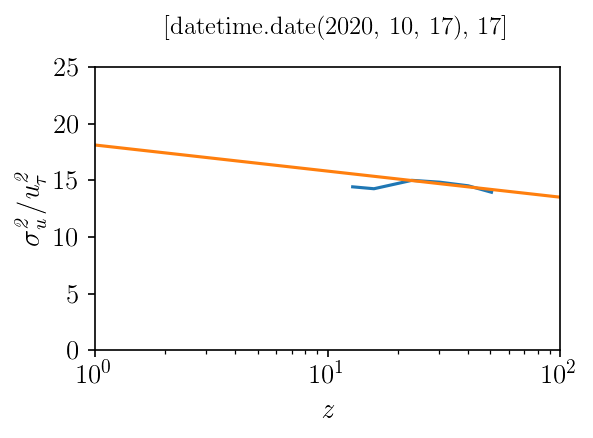

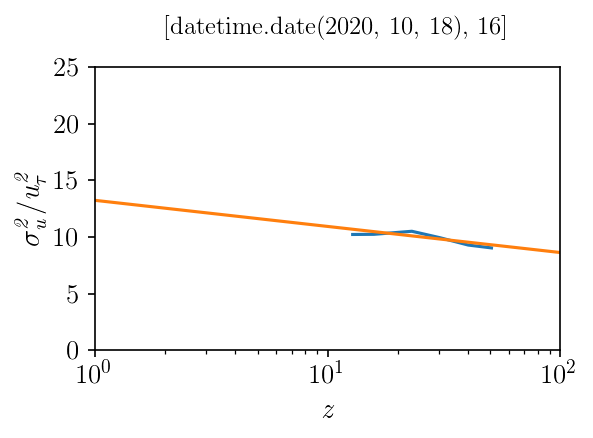

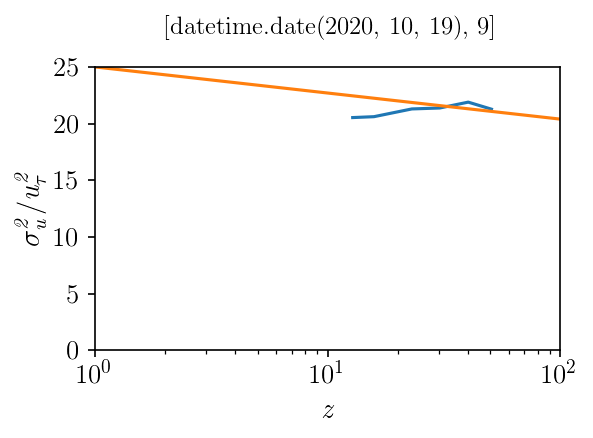

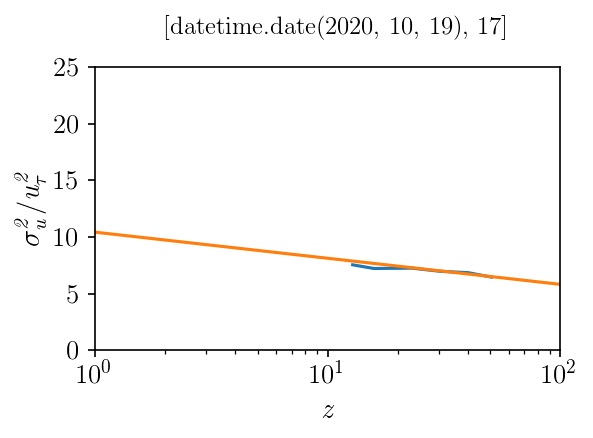

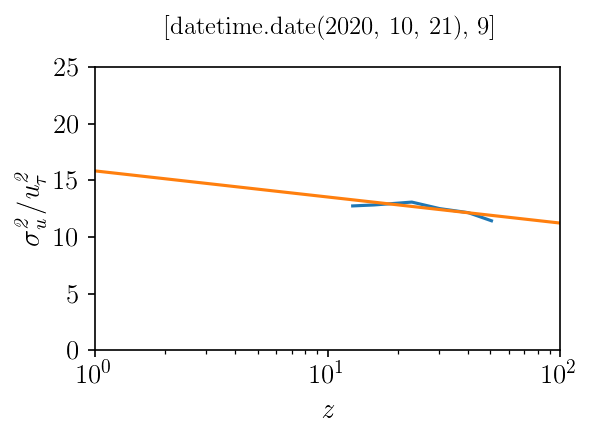

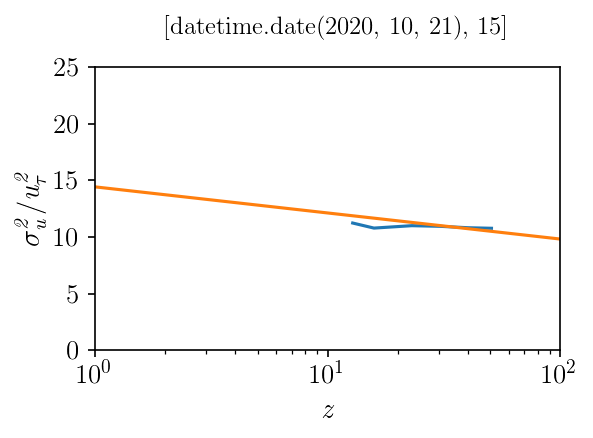

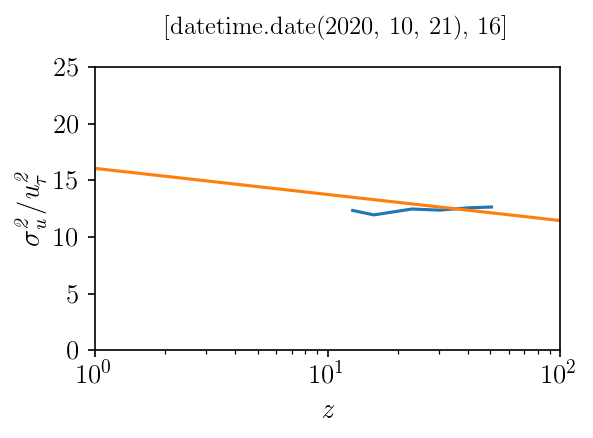

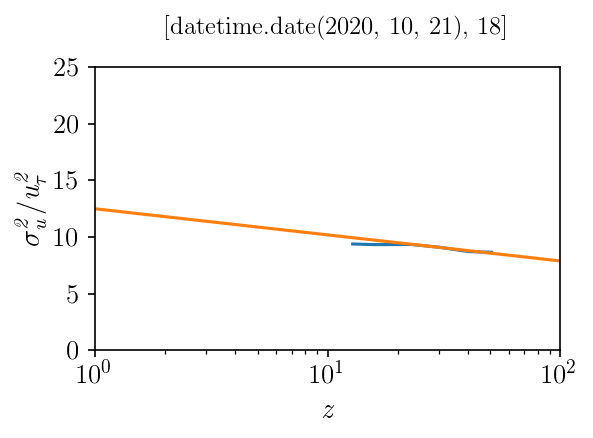

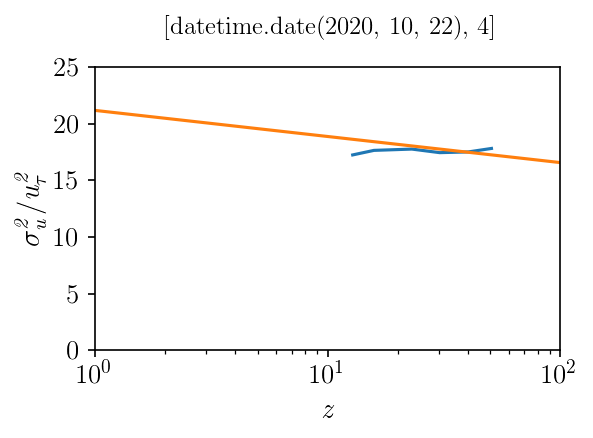

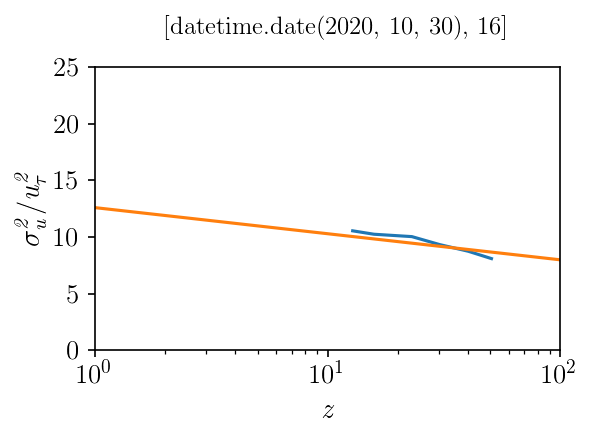

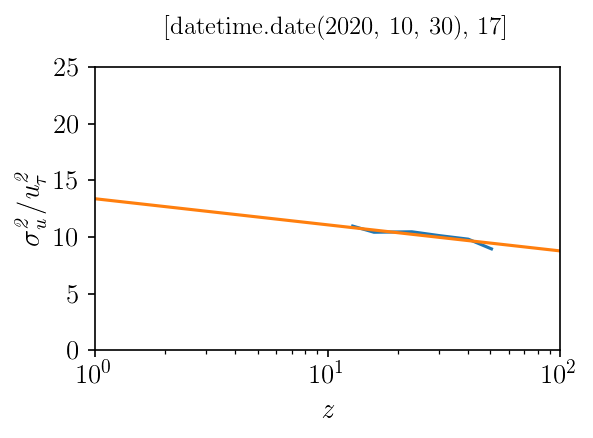

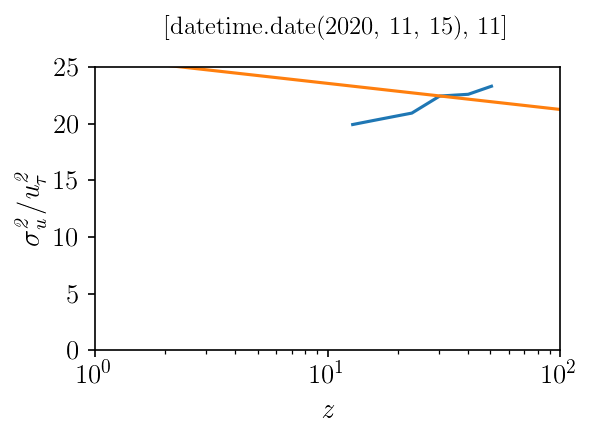

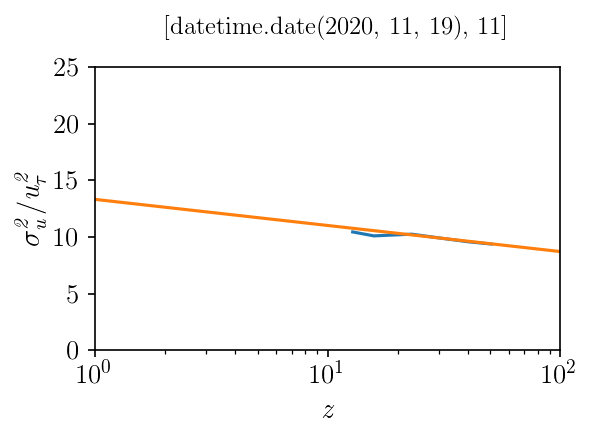

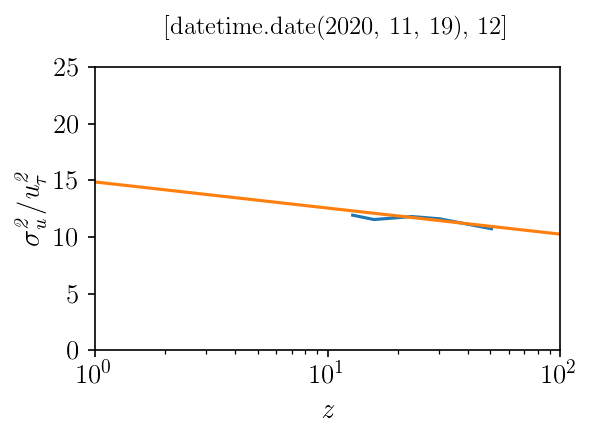

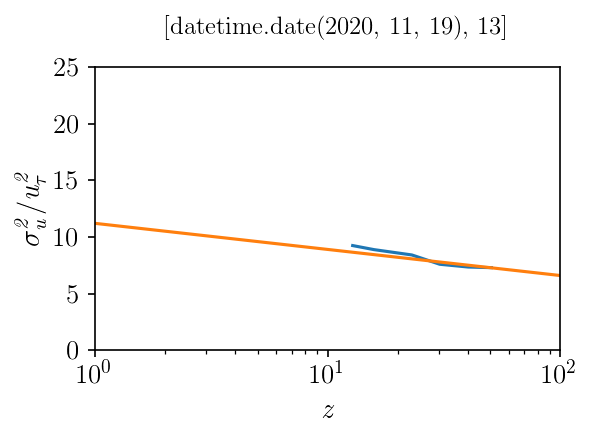

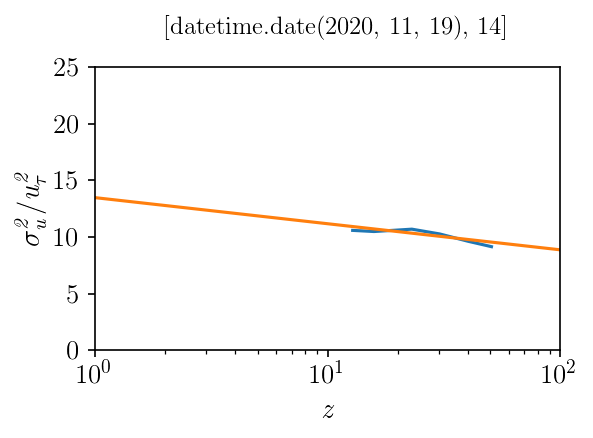

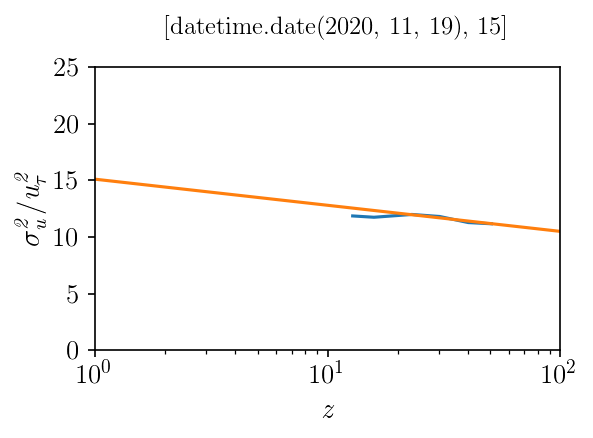

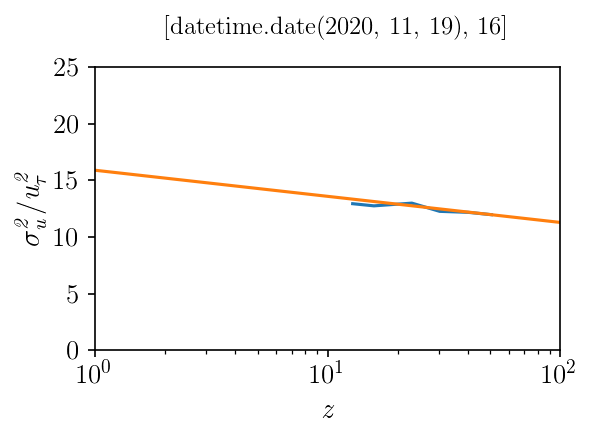

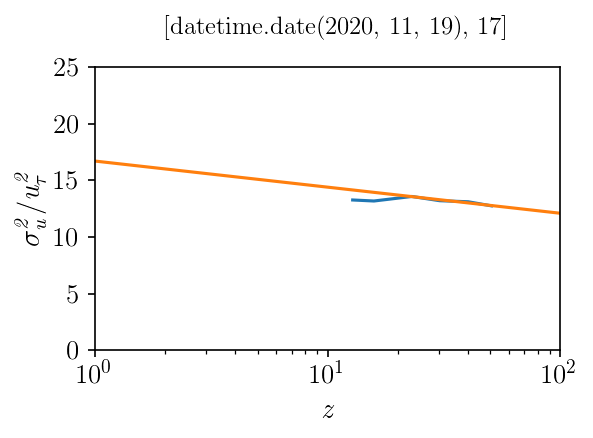

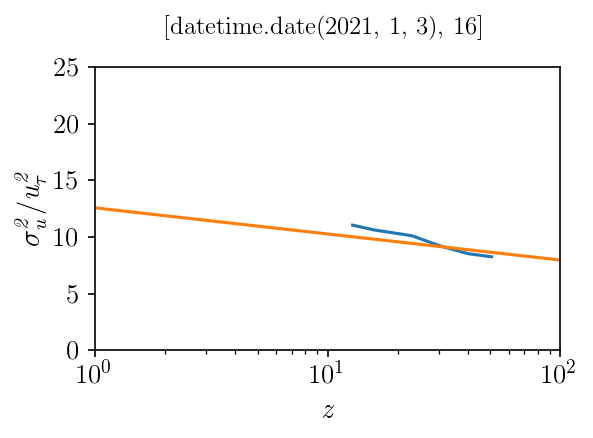

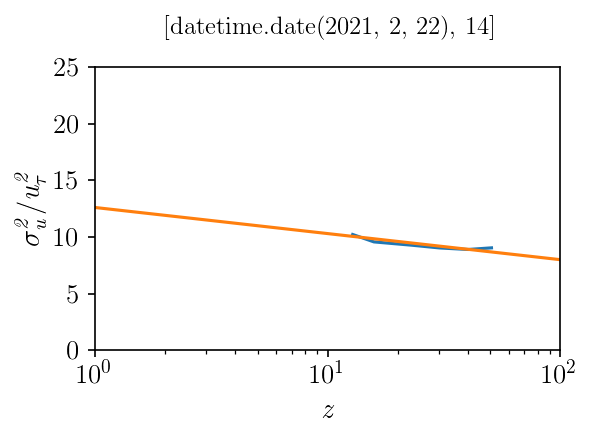

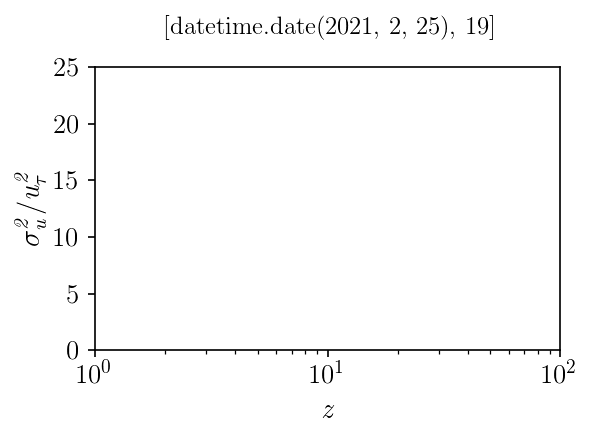

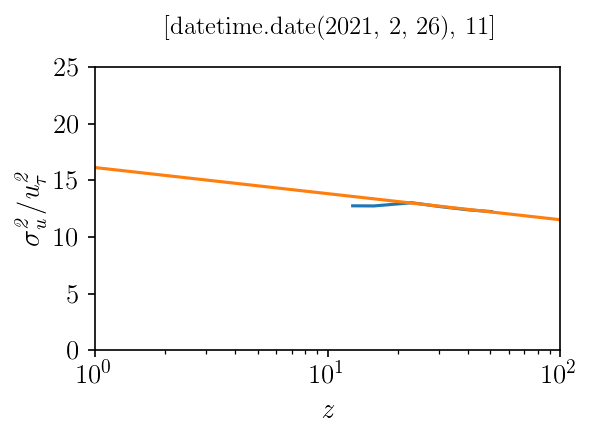

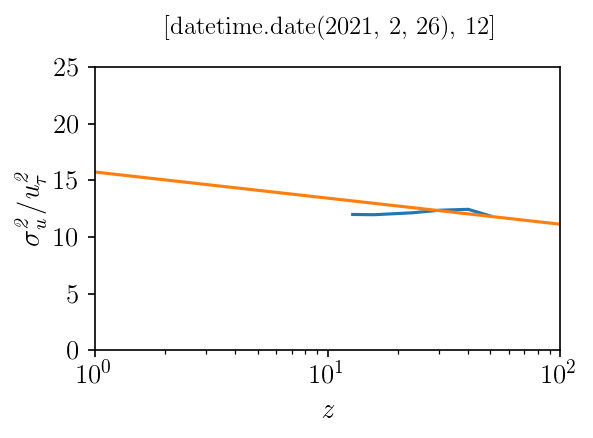

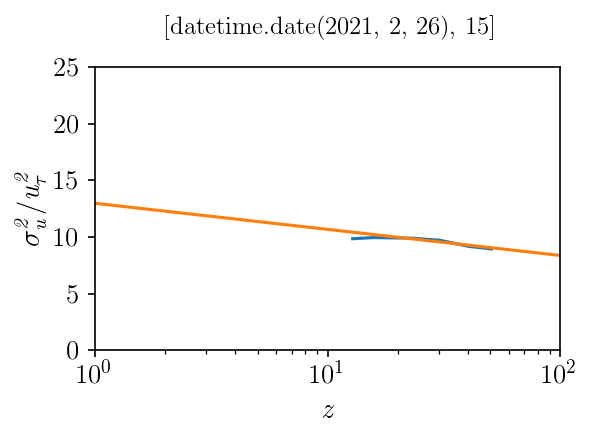

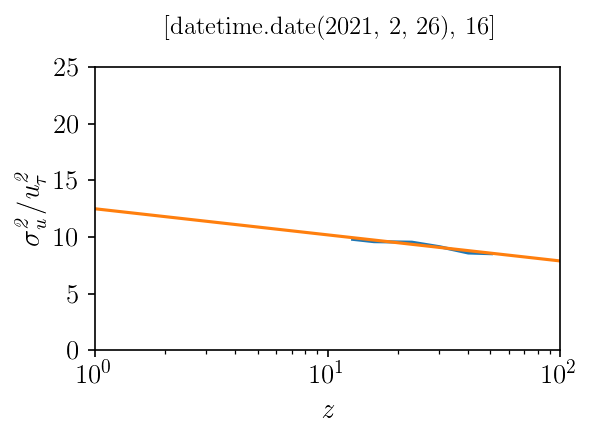

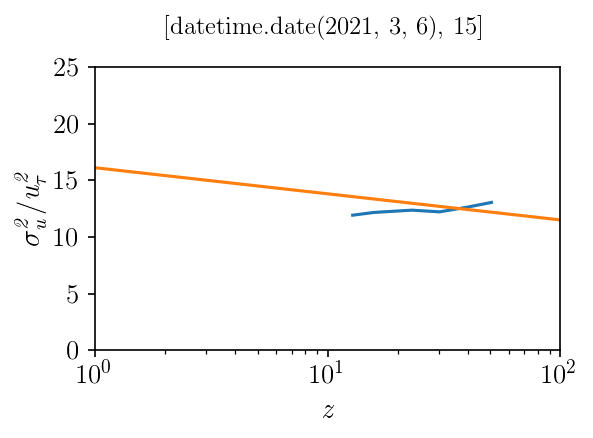

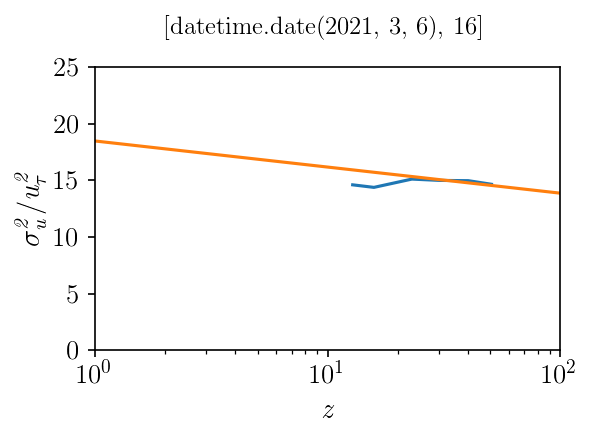

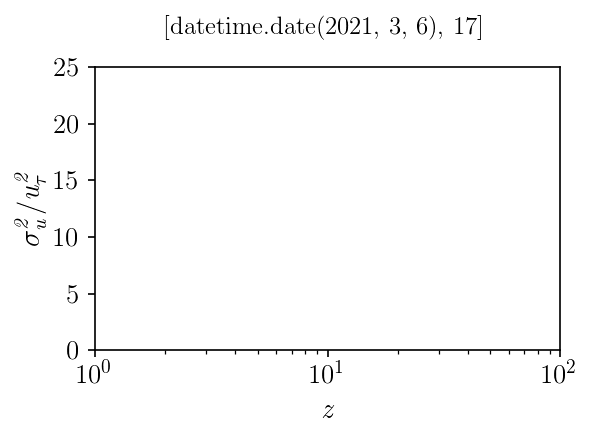

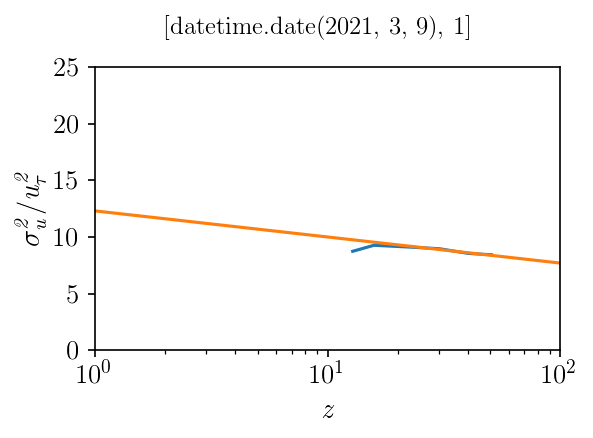

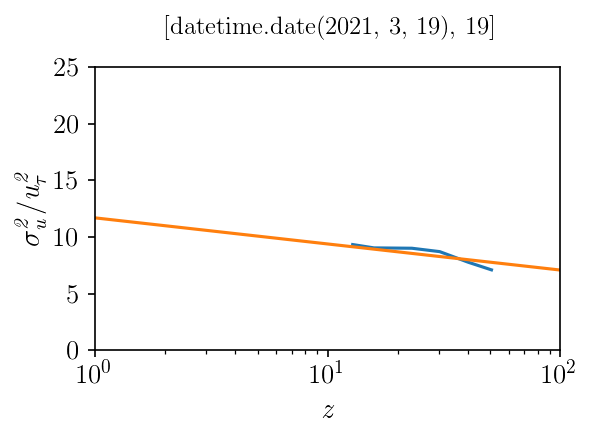

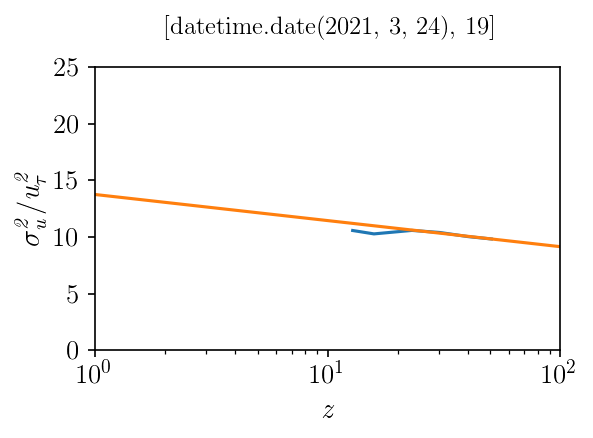

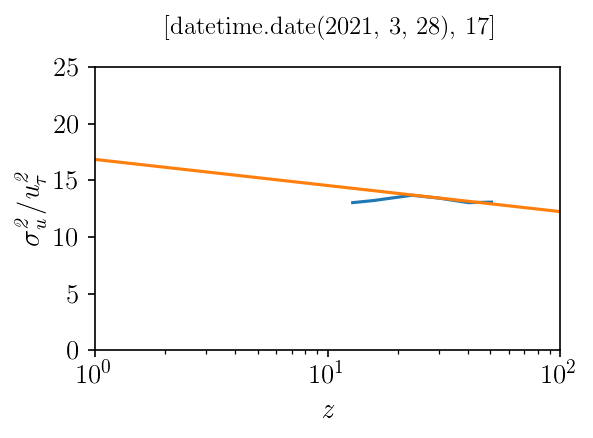

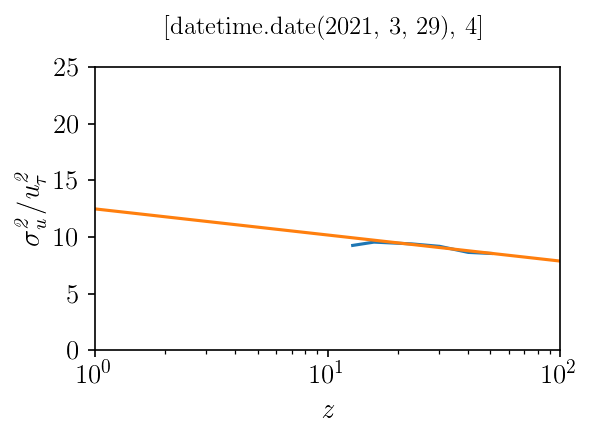

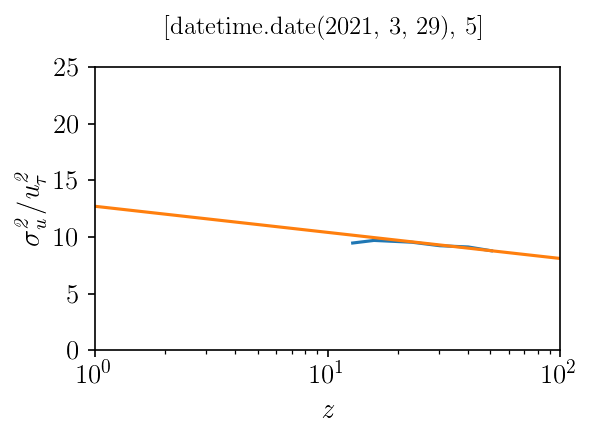

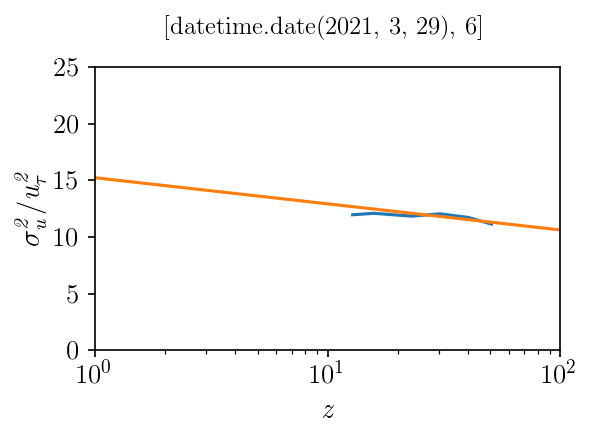

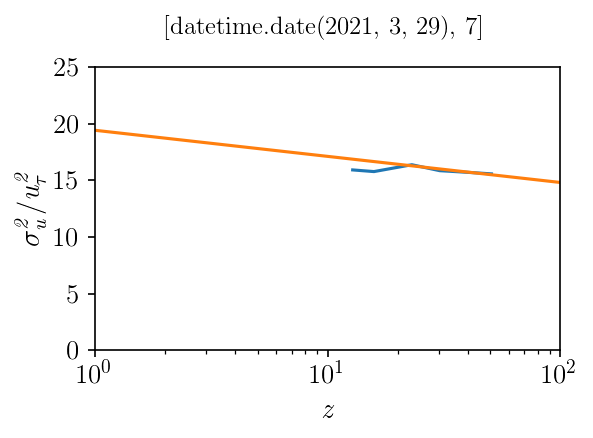

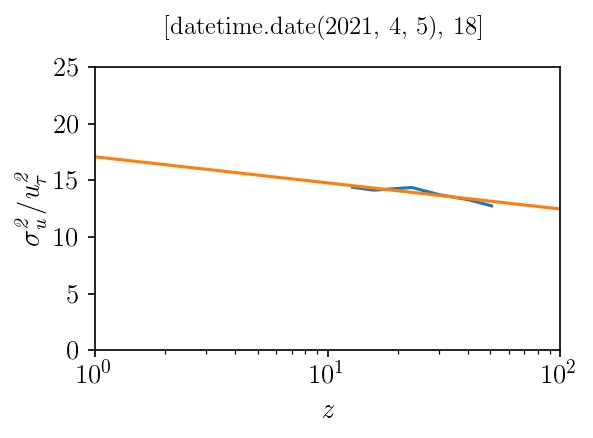

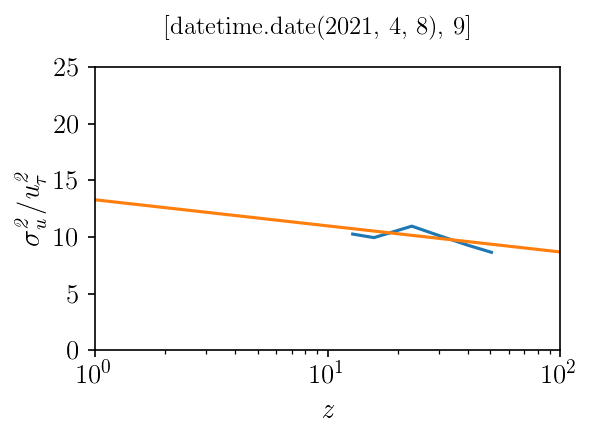

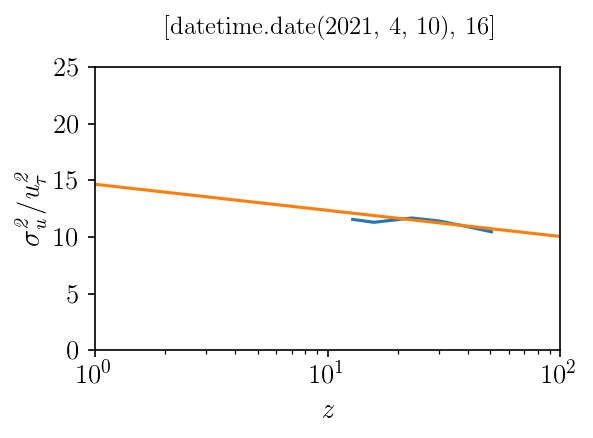

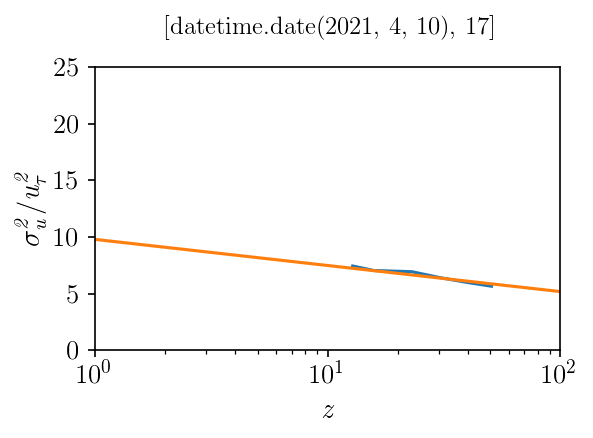

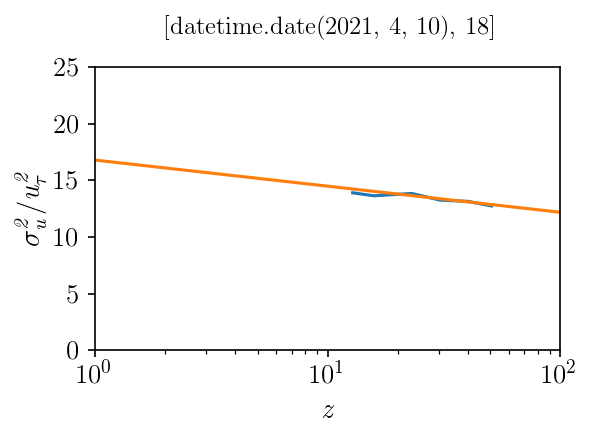

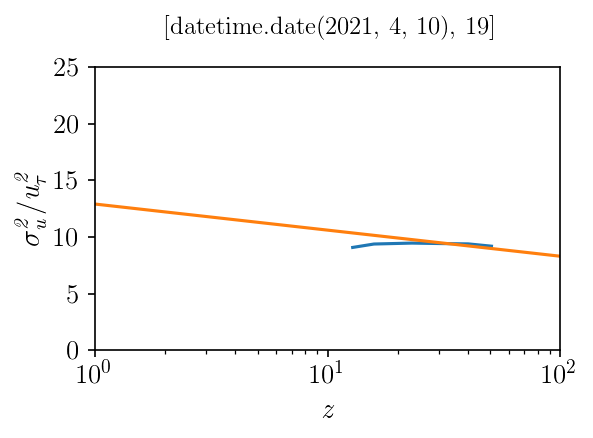

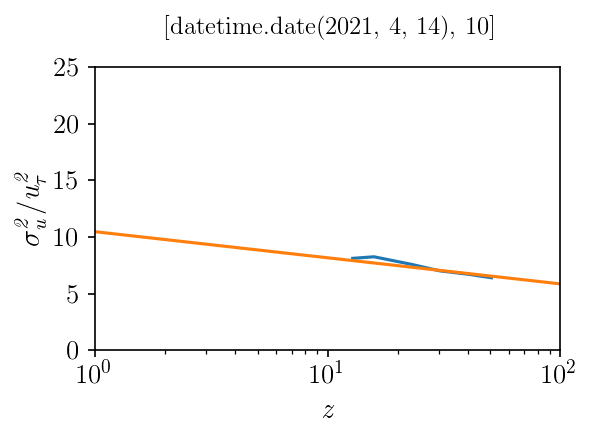

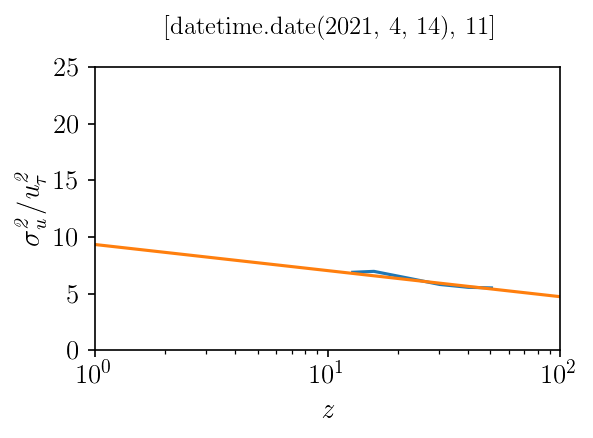

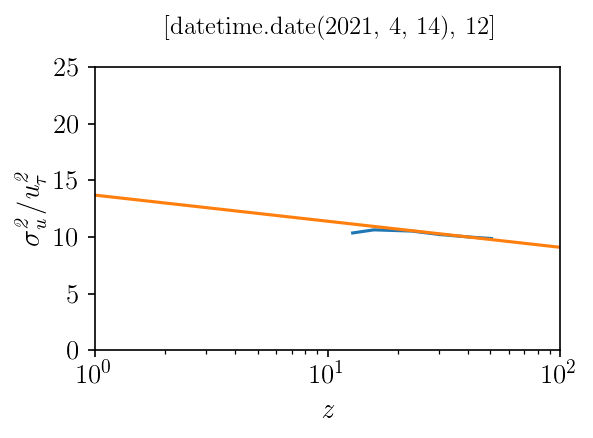

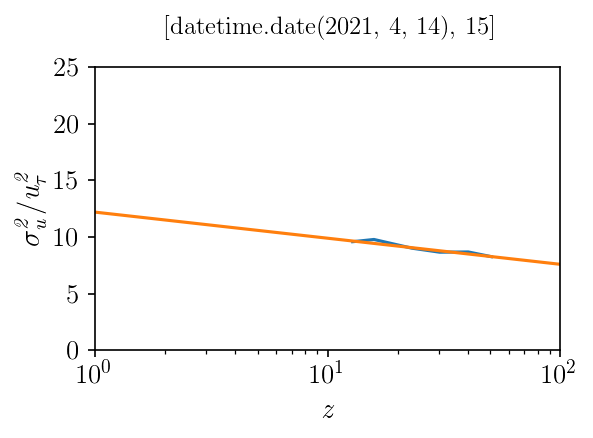

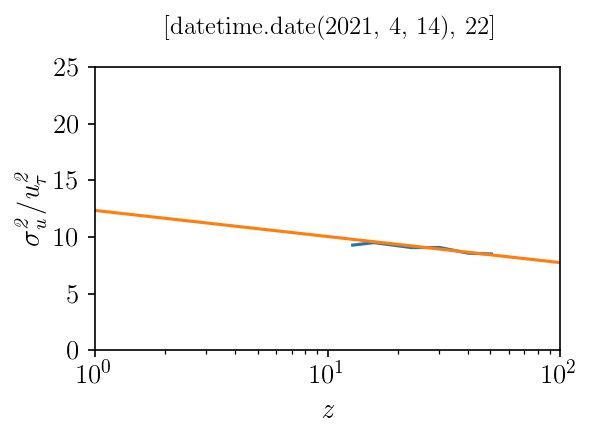

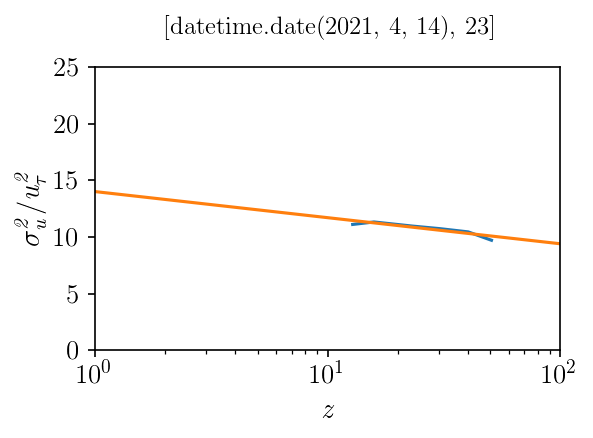

In [37]:
for i in np.arange(0,61):
    plt.figure(figsize=(4, 2.5), dpi=150)
    plt.plot(z[list_sel_m2],u_std_plus2[i,list_sel_m1])
    y1_test=np.logspace(-4,2,100)
    plt.plot(y1_test,B1-A1*np.log(y1_test/delta2[i]))
    plt.text(2,28,neutral_case[i], fontsize = 12)
    plt.xlabel(r'$\it z$', fontsize = font_size)
    plt.ylabel(r'$\it \sigma_u^2/u_{\tau}^2$', fontsize = font_size)
    plt.xlim(1, 1e2)
    plt.ylim(0, 25)
    ax = plt.gca()
    ax.set_xscale('log')
# plt.savefig(OUT_DIRECTORY + 'neutral_hour_hist.png', dpi=200)